# OLID-BR (EDA)

In this notebook, we will explore the data in the OLID-BR dataset.

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from src.settings import AppSettings
from src.processing.spans import get_toxic_substrings
from src.modeling.utils import download_dataset

%matplotlib inline

args = AppSettings()

In [17]:
data = download_dataset(file="olidbr.csv")

print(f"Shape: {data.shape}")
data.head()

Shape: (4676, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


In [18]:
metadata = download_dataset(file="metadata.csv")

print(f"Shape: {metadata.shape}")
metadata.head()

Shape: (17416, 12)


,id,source,created_at,collected_at,toxicity_score,category,annotator_id,gender,age,education_level,annotator_type,year_of_birth
0,6391e3dbb12848ac8ef6131edf2d69f9,Twitter,2021-12-28T15:52:02+00:00,2021-12-28T09:27:13.610956,0.7424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6391e3dbb12848ac8ef6131edf2d69f9,NaN,NaN,NaN,NaN,NaN,32.0,Female,30.0,Bachelor's degree,Volunteer,NaN
2,6391e3dbb12848ac8ef6131edf2d69f9,NaN,NaN,NaN,NaN,NaN,1.0,Male,28.0,Bachelor's degree,Researcher,NaN
3,5a21508c2afc4c3295137451baf8b981,Twitter,2021-12-28T16:58:00+00:00,2021-12-28T09:27:13.610956,0.8707,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5a21508c2afc4c3295137451baf8b981,NaN,NaN,NaN,NaN,NaN,32.0,Female,30.0,Bachelor's degree,Volunteer,NaN


## Data Exploration

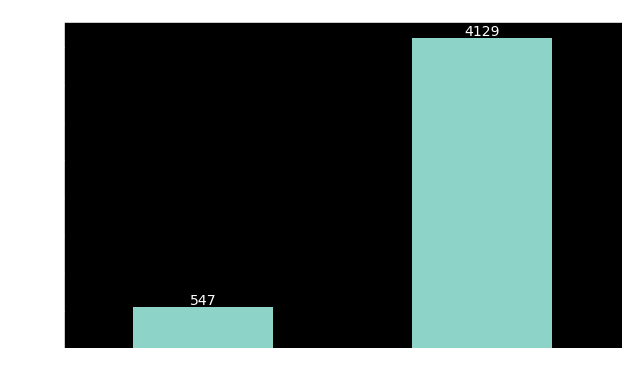

In [19]:
df_temp = data[["text", "is_offensive"]].groupby("is_offensive").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="is_offensive", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="is_offensive", ylabel="count", fontsize=14,
                 rot=1, title="is_offensive distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

In [20]:
def get_toxicity_score(metadata: pd.DataFrame, text_id: str) -> float:
    """Get the toxicity score for a given text_id

    Args:
    - metadata: the metadata dataframe
    - text_id: the text_id
    
    Returns:
    - the toxicity score
    """
    return metadata[(metadata.id == text_id) & (~metadata["toxicity_score"].isnull())].toxicity_score.values[0]

data["toxicity_score"] = data.id.apply(lambda x: get_toxicity_score(metadata, x))

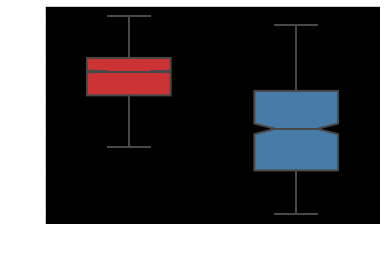

In [21]:
ax = sns.boxplot(x="is_offensive", y="toxicity_score", data=data,
                 palette="Set1", linewidth=2, fliersize=2,
                 width=0.5, showfliers=False, notch=True,
                 whis=1.5, ax=None)

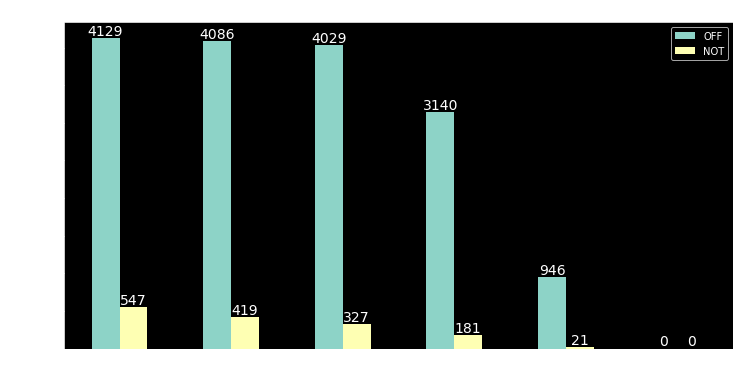

In [22]:
# plot the number of is_offensive per toxicity bin
df_temp = data[["is_offensive", "toxicity_score"]].copy()

df_temp["toxicity_bin"] = df_temp.toxicity_score.apply(lambda x: round(x, 1))
df_temp

# Count the number of is_offensive per toxicity bin
tmp = {}

for bin in df_temp["toxicity_bin"].unique():
    tmp[bin] = {
        "OFF": df_temp[(df_temp["toxicity_score"] >= bin) & (df_temp["is_offensive"] == "OFF")].shape[0],
        "NOT": df_temp[(df_temp["toxicity_score"] >= bin) & (df_temp["is_offensive"] == "NOT")].shape[0]
    }

df_temp = pd.DataFrame(tmp)
df_temp = df_temp.transpose()
df_temp.sort_index(inplace=True)
df_temp.reset_index(inplace=True)
df_temp.rename(columns={"index": "toxicity_bin"}, inplace=True)

ax = df_temp.plot(x="toxicity_bin", kind="bar",
                    legend=True, figsize=(12, 6),
                    xlabel="toxicity_bin", ylabel="count", fontsize=14,
                    rot=1, title="is_offensive distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

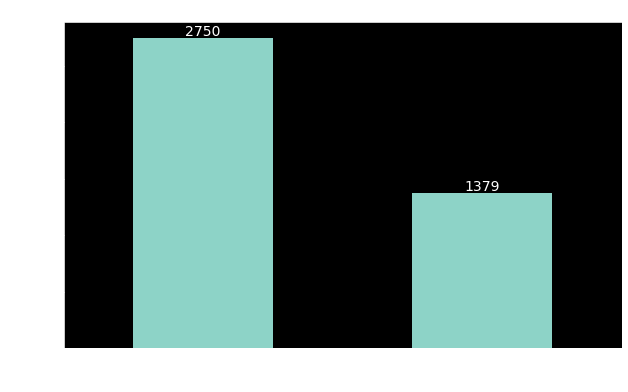

In [23]:
df_temp = data[data["is_offensive"] == "OFF"][["text", "is_targeted"]].groupby("is_targeted").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="is_targeted", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="is_targeted", ylabel="count", fontsize=14,
                 rot=1, title="is_targeted distribution (only if is_offensive = 'OFF')")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

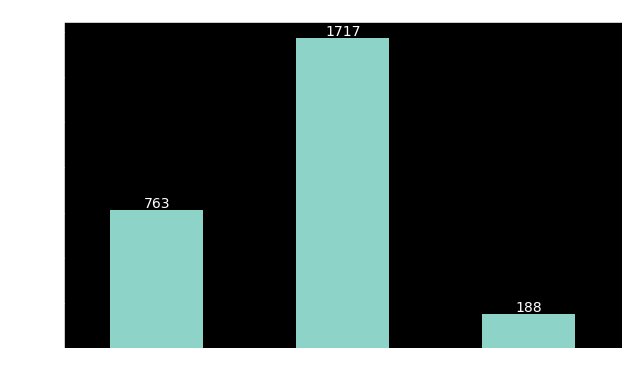

In [24]:
df_temp = data[(data["is_offensive"] == "OFF") & (data["is_targeted"] == "TIN")]
df_temp = df_temp[["text", "targeted_type"]].groupby("targeted_type").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="targeted_type", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="targeted_type", ylabel="count", fontsize=14,
                 rot=1, title="targeted_type distribution (only if is_offensive = 'OFF' and is_targeted = 'TIN')")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

## Word Cloud for toxic words

In the next cells, we will generate a word cloud for the toxic words in the dataset.

First, we will get the substrings based on `toxic_spans` field.

Then, we will generate a word cloud for the toxic words.

In [25]:
toxic_substrs = []

for row in data.to_dict(orient="records"):
    if isinstance(row.get("toxic_spans"), list) and len(row.get("toxic_spans")) > 0:
        toxic_substrs.extend(get_toxic_substrings(row["text"], row["toxic_spans"]))
        
print(f"toxic_substrs: {len(toxic_substrs)}")

toxic_substrs: 0


In [28]:
data

,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia,toxicity_score
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False,0.7424
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False,0.8707
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False,0.5283
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False,0.7357
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False,0.8999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,c7965d594c2a4f5a96578ef3a2782ecb,vou com um shortinho beira cu mas tenho vergon...,OFF,TIN,OTH,"[26, 27, 28, 71, 72, 73, 74]",False,False,True,False,False,False,True,False,False,False,False,0.8004
4672,543ab0252cf749a6bee0ff1fd902c94f,Mas no Brasil USER tem que ser louco !! E ter ...,OFF,UNT,NaN,"[31, 32, 33, 34, 35, 161, 162, 163, 164, 165]",False,False,False,False,False,False,True,False,False,False,False,0.8328
4673,bf8ce09c842746a697df07c1d59417f6,BISHO TU SO SABE FLR ISSO É? VAI TE FUDER,OFF,TIN,IND,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]",False,False,True,False,False,False,True,False,False,False,False,0.9873
4674,b436fbba868640c49c6c6a74e87ec485,Não sou a favor a violência mas isso que acont...,OFF,TIN,IND,"[118, 119, 120, 121, 122, 123, 124, 125, 126, ...",True,True,True,False,False,True,False,False,False,False,False,0.7106


In [26]:
wc = WordCloud(width=1920, height=1024,
               max_words=200, max_font_size=100)

wc.generate(" ".join(toxic_substrs))

plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [27]:
data[data["toxic_spans"].isnull()]["text"].tolist()

['USER O partido do Kim votou à favor do fundão. Mas o machão fica quietinho.',
 'USER Então porque as professoras,as políticas femininas ganham um salário de miséria',
 'USER USER Tu nem podia tá falando aí condenado em primeira e segunda estância',
 'USER Esquerda querendo falar de corrupção É de matar kkkk',
 'USER Que ódio, já amei!',
 'USER USER',
 'USER Tão bonitinho, vai sofre tanto tadinho',
 'USER USER to sentindo q esse cara vai fazer história',
 'USER tadeu roubou a gimmick do sammy g USER',
 '🏆 Categoria: MEU B.O. FAVORITO 🏆 E os vencedores são: Gilberto, Pocah e a treta do basculho Assista AO VIVO ao HASHTAG → URL HASHTAG HASHTAG URL',
 'RT USER: A treta está intensa por aqui! Segundo o USER, a USER não se aproxima dele por medo do público.…',
 'RT USER: O time vencedor deverá mostrar que entende de proteína suína! Para quem vai a sua torcida? HASHTAG Ana G., Manu…',
 'RT USER: O Fazendeiro USER já pensa em como irá fazer para delegar novamente a tarefa da peoa que será el